In [1]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import sklearn.metrics
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re


In [2]:
n_rows = 5000
n_signal_variables = 10
n_noise_variables = 100
n_levels = 500

In [3]:
d = pandas.DataFrame({"y":0.01*numpy.random.normal(size = n_rows)})

In [4]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.uniform(low=-10, high=10, size=1)[0]
    return values

In [5]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [6]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [7]:
d.head()

,y,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,noise_90,noise_91,noise_92,noise_93,noise_94,noise_95,noise_96,noise_97,noise_98,noise_99
0,13.419078,level_266,level_81,level_402,level_251,level_98,level_11,level_383,level_201,level_261,...,level_112,level_174,level_197,level_407,level_77,level_238,level_364,level_334,level_84,level_129
1,-2.379785,level_78,level_107,level_453,level_413,level_20,level_453,level_96,level_7,level_323,...,level_281,level_269,level_1,level_109,level_20,level_302,level_212,level_197,level_137,level_451
2,-17.515265,level_132,level_224,level_429,level_480,level_258,level_439,level_178,level_444,level_319,...,level_201,level_270,level_354,level_443,level_306,level_244,level_118,level_354,level_491,level_408
3,-9.909441,level_457,level_200,level_134,level_8,level_146,level_293,level_323,level_111,level_480,...,level_433,level_357,level_268,level_216,level_247,level_300,level_10,level_384,level_376,level_248
4,-2.556636,level_389,level_322,level_239,level_353,level_425,level_197,level_198,level_202,level_410,...,level_188,level_135,level_432,level_322,level_372,level_113,level_127,level_130,level_240,level_170


In [8]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [9]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [10]:
plan = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                       'coders':['impact_code']}))
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train_hierarchical = plan.transform(d_train)

In [11]:
p2 = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                     'coders':['impact_code'],
                                                                     'use_hierarchical_estimate':False}))
p2.fit_transform(d_train, y_train)
naive_train_empirical = p2.transform(d_train)

In [12]:
naive_train_empirical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-1.259102,14.991797,-0.025726,3.367399,20.813586,3.608245,10.169389,7.641217,-2.388793,5.725904,...,11.126118,9.506287,14.726431,1.424471,8.285324,-11.487518,0.297854,10.465397,-8.478523,4.196906
1,-14.783637,-15.801071,9.173472,-8.264172,10.184169,-18.614386,-4.691770,3.160954,2.455386,11.317265,...,3.111445,-0.391865,-4.302385,4.945618,-2.987789,11.343097,-1.125471,-2.287948,2.305191,5.924199
2,1.152988,-2.776662,-35.996342,-19.379379,-10.026485,-11.542165,-15.668439,-2.259530,0.897026,-7.536684,...,-6.863654,-1.138343,12.267219,-4.409126,-4.257907,-1.049752,-0.019268,-5.537041,-0.773165,-7.973097
3,-10.656798,-2.974184,10.715101,14.696015,6.315167,9.604926,5.229203,-0.737143,3.458782,-8.623120,...,0.435011,2.262424,-3.389814,-1.023104,15.864676,-12.133844,-3.673718,-8.614915,15.481586,4.194458
4,-1.827466,15.662568,3.139034,-1.466709,5.184239,-3.419649,-0.679834,-15.881820,15.439690,7.964265,...,6.078339,-12.432309,7.826144,-14.361873,-1.785126,-4.652484,4.066486,-15.588621,5.604585,-2.459065


In [13]:
naive_train_hierarchical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-0.794070,13.272424,-0.019200,2.611361,15.254872,3.075146,7.754925,5.910893,-1.469713,4.374075,...,5.759506,3.822039,14.581697,0.873765,5.658630,-6.587624,0.136433,6.287707,-5.473740,2.450379
1,-11.527322,-3.453556,6.671939,-7.015518,9.130733,-9.248052,-4.063348,2.729607,1.370242,8.279517,...,2.532591,-0.216912,-3.523041,2.796388,-2.761082,7.218593,-0.721285,-1.046211,2.095731,5.253755
2,0.711292,-1.455015,0.000000,-13.734040,-5.553115,-5.111004,-8.904804,-0.812081,0.431122,-3.967350,...,-3.338929,-0.767341,3.564150,-1.346709,-2.993043,-0.814580,-0.013803,-3.446590,-0.468781,-3.123920
3,-4.876559,-2.101106,6.214809,11.453189,4.831972,6.665868,4.315210,-0.557957,3.365537,-5.218259,...,0.130722,1.632632,-2.800583,-0.655910,11.554479,-1.405167,-1.873424,-4.456294,4.063587,2.777154
4,-1.330993,5.449252,2.483477,-1.004020,2.611592,-3.232417,-0.529499,-6.314222,9.006410,6.514789,...,2.503976,-7.791149,6.203221,-8.637309,-0.715301,-3.698586,2.757014,-7.714579,4.379548,-2.118573


In [14]:
cross_frame.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-1.685757e+00,8.104132,-5.614259,-0.669837,7.149721,3.513566,6.778546,0.994607,-0.803084,4.739112,...,4.989502,1.506979,0.000000,-0.493128,5.419536,-9.334157,-4.972542,4.194878,-7.077957,3.544256
1,-1.276570e+01,0.000000,12.626860,0.000000,9.604152,-26.222884,-9.969220,0.000000,1.109760,5.058063,...,1.207788,-0.334671,-3.525794,1.449502,-5.458674,5.654921,0.325058,0.763539,1.322926,4.960464
2,6.362586e+00,4.246852,0.000000,-11.793508,-2.533365,-3.066810,-6.759013,5.651477,4.862723,0.446169,...,-2.129593,2.740178,6.499609,1.077980,-0.498351,2.215430,6.884852,-0.642789,2.132612,-1.769031
3,-5.676009e+00,-1.714819,6.053224,11.104548,5.368449,6.277036,2.646774,-2.289636,2.367003,-7.834611,...,-0.222836,2.283007,-0.362044,0.656019,13.411458,0.000000,-3.458090,-2.156435,0.000000,3.545481
4,1.110223e-16,8.681112,5.144047,-0.020478,-1.839391,-2.491478,-7.142445,0.000000,12.490283,7.709339,...,1.369381,-7.704733,1.658133,-9.085245,0.000000,-3.138628,12.231018,-11.823501,6.550834,-0.927444


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_empirical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_empirical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["naive_train_hierarchical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_hierarchical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_empirical_correlation,naive_train_hierarchical_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.530555,0.506496,0.162571,0.157652,False
1,var_1_impact_code,0.504529,0.473431,0.131852,0.159193,False
2,var_2_impact_code,0.530921,0.504960,0.144619,0.163555,False
3,var_3_impact_code,0.522149,0.494247,0.166523,0.218104,False
4,var_4_impact_code,0.533481,0.511255,0.178776,0.186847,False
5,var_5_impact_code,0.531288,0.507268,0.165936,0.185732,False
6,var_6_impact_code,0.520520,0.497296,0.149536,0.196029,False
7,var_7_impact_code,0.514118,0.486265,0.133891,0.167155,False
8,var_8_impact_code,0.523501,0.503332,0.161315,0.206330,False
9,var_9_impact_code,0.534390,0.514412,0.181625,0.172697,False


(0.8576532341770212, 5.680213168928185e-33)


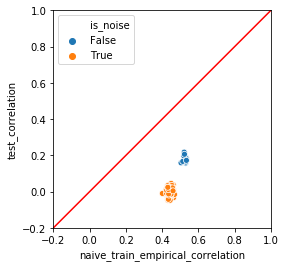

In [16]:
print(scipy.stats.pearsonr(corr_frame['naive_train_empirical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_empirical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.867292559646538, 1.6849170163682413e-34)


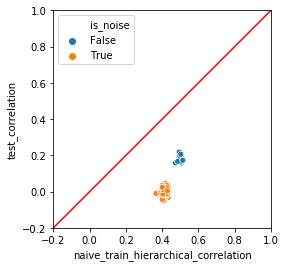

In [17]:
print(scipy.stats.pearsonr(corr_frame['naive_train_hierarchical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_hierarchical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8373172625649289, 4.345594234347931e-30)


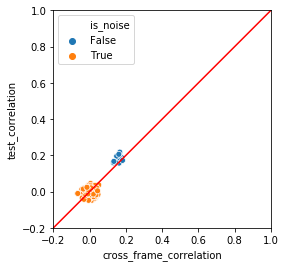

In [18]:
print(scipy.stats.pearsonr(corr_frame['cross_frame_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [19]:
plan.score_frame_.tail()

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
105,noise_95_impact_code,noise_95,impact_code,True,True,0.007340,0.710654,110.0,False
106,noise_96_impact_code,noise_96,impact_code,True,True,-0.009254,0.639970,110.0,False
107,noise_97_impact_code,noise_97,impact_code,True,True,-0.007724,0.696241,110.0,False
108,noise_98_impact_code,noise_98,impact_code,True,True,-0.014596,0.460667,110.0,False
109,noise_99_impact_code,noise_99,impact_code,True,True,0.043879,0.026499,110.0,False


In [20]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code',
 'var_1_impact_code',
 'var_2_impact_code',
 'var_3_impact_code',
 'var_4_impact_code',
 'var_5_impact_code',
 'var_6_impact_code',
 'var_7_impact_code',
 'var_8_impact_code',
 'var_9_impact_code']

In [21]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [22]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [23]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [24]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [25]:
fitter.fit(naive_train_empirical[all_vars], y_train)
plot_train["predict_naive_empirical_all_vars"] = fitter.predict(naive_train_empirical[all_vars])
plot_test["predict_naive_empirical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [26]:
fitter.fit(naive_train_hierarchical[all_vars], y_train)
plot_train["predict_naive_hierarchical_all_vars"] = fitter.predict(naive_train_hierarchical[all_vars])
plot_test["predict_naive_hierarchical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [27]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_empirical_all_vars,predict_naive_hierarchical_all_vars
0,-2.379785,0.114625,0.570131,0.781264,1.301980
1,-17.515265,4.871634,-1.217827,1.570820,3.232252
2,-9.909441,12.029390,7.162540,-1.990842,-2.934652
3,39.347396,9.009170,12.765120,1.597430,3.120576
4,6.527597,8.262219,8.654824,-1.561180,-2.120322


In [28]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

3.2675212384564536


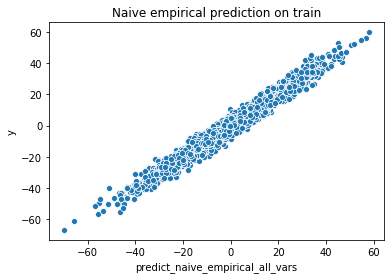

In [29]:
print(rmse(plot_train["predict_naive_empirical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive empirical prediction on train")

4.790348749510059


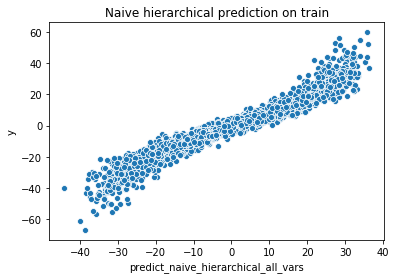

In [30]:
print(rmse(plot_train["predict_naive_hierarchical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on train")

15.53114521383251


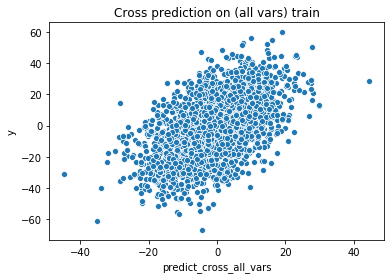

In [31]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

15.998173526311675


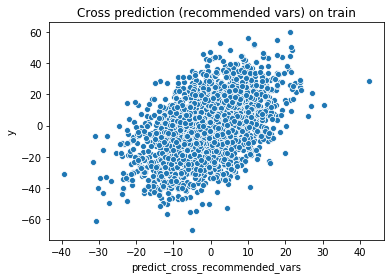

In [32]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

17.972033252889105


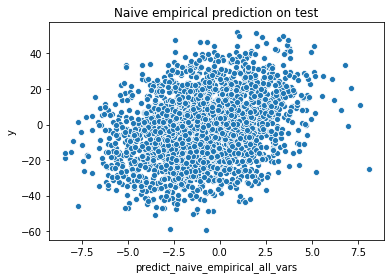

In [33]:
print(rmse(plot_test["predict_naive_empirical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive empirical prediction on test")

17.581312869260252


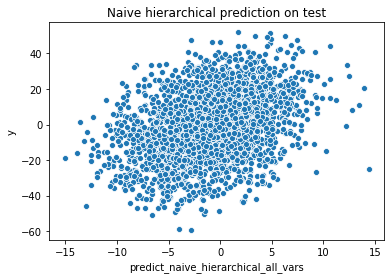

In [34]:
print(rmse(plot_test["predict_naive_hierarchical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on test")

15.799053445992387


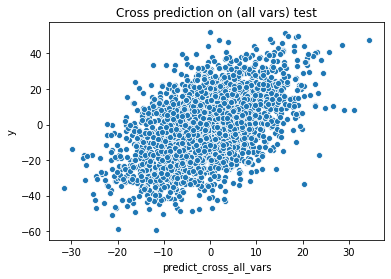

In [35]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

15.423578277022628


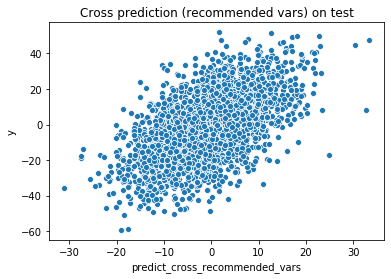

In [36]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [37]:
smf1 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train_empirical[all_vars])).fit()
smf1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     678.8
Date:                Sun, 28 Jul 2019   Prob (F-statistic):               0.00
Time:                        09:55:49   Log-Likelihood:                -6655.8
No. Observations:                2557   AIC:                         1.353e+04
Df Residuals:                    2446   BIC:                         1.418e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.9731      0.066    -14.728      0.000      -1.103      -0.843
var_0_impact_code        0.0661      0.008      8.146      0.000       0.050       0.082
var_1_impact_code        0.0687      0.008      8.218      0.000       0.052       0.085
var_2_impact_code        0.0563      0.008      6.915      0.000       0.040       0.072
var_3_impact_code        0.0743      0.008      9.107      0.000       0.058       0.090
var_4_impact_code        0.0654      0.008      8.103      0.000       0.050       0.081
var_5_impact_code        0.0811      0.008     10.025      0.000       0.065       0.097
var_6_impact_code        0.0625      0.008      7.623      0.000       0.046       0.079
var_7_impact_code        0.0643      0.008      7.732      0.000       0.048       0.081
var_8_impact_code        0.0703      0.008      8.599      0.000       0.054       0.086
var_9_impact_code        0.0606      0.008      7.507      0.000       0.045       0.076
noise_0_impact_code      0.0401      0.010      4.184      0.000       0.021       0.059
noise_1_impact_code      0.0289      0.009      3.180      0.001       0.011       0.047
noise_2_impact_code      0.0301      0.009      3.360      0.001       0.013       0.048
noise_3_impact_code      0.0376      0.009      4.113      0.000       0.020       0.055
noise_4_impact_code      0.0324      0.009      3.498      0.000       0.014       0.051
noise_5_impact_code      0.0342      0.009      3.609      0.000       0.016       0.053
noise_6_impact_code      0.0335      0.009      3.637      0.000       0.015       0.052
noise_7_impact_code      0.0402      0.009      4.348      0.000       0.022       0.058
noise_8_impact_code      0.0463      0.009      5.074      0.000       0.028       0.064
noise_9_impact_code      0.0295      0.009      3.291      0.001       0.012       0.047
noise_10_impact_code     0.0591      0.009      6.605      0.000       0.042       0.077
noise_11_impact_code     0.0476      0.009      5.180      0.000       0.030       0.066
noise_12_impact_code     0.0437      0.009      4.896      0.000       0.026       0.061
noise_13_impact_code     0.0435      0.009      4.705      0.000       0.025       0.062
noise_14_impact_code     0.0535      0.009      5.801      0.000       0.035       0.072
noise_15_impact_code     0.0446      0.009      4.858      0.000       0.027       0.063
noise_16_impact_code     0.0178      0.009      1.951      0.051   -8.75e-05       0.036
noise_17_impact_code     0.0298      0.009      3.278      0.001       0.012       0.048
noise_18_impact_code     0.0446      0.009      4.810      0.000       0.026       0.063
noise_19_impact_code     0.0472      0.009      5.096      0.000       0.029       0.065
noise_20_impact_code     0.0439      0.010      4.624    

In [38]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_naive_empirical_all_vars"])

0.9682810156943022

In [39]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_naive_empirical_all_vars"])

0.06616962921279901

In [40]:
smf2 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     8.793
Date:                Sun, 28 Jul 2019   Prob (F-statistic):          2.37e-111
Time:                        09:55:49   Log-Likelihood:                -10642.
No. Observations:                2557   AIC:                         2.151e+04
Df Residuals:                    2446   BIC:                         2.215e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.9537      0.318     -2.995      0.003      -1.578      -0.329
var_0_impact_code        0.3681      0.048      7.622      0.000       0.273       0.463
var_1_impact_code        0.3711      0.051      7.316      0.000       0.272       0.471
var_2_impact_code        0.2942      0.047      6.255      0.000       0.202       0.386
var_3_impact_code        0.4477      0.049      9.104      0.000       0.351       0.544
var_4_impact_code        0.4702      0.047      9.904      0.000       0.377       0.563
var_5_impact_code        0.4276      0.046      9.277      0.000       0.337       0.518
var_6_impact_code        0.4169      0.050      8.378      0.000       0.319       0.515
var_7_impact_code        0.3376      0.050      6.756      0.000       0.240       0.436
var_8_impact_code        0.4832      0.049      9.861      0.000       0.387       0.579
var_9_impact_code        0.4683      0.047      9.876      0.000       0.375       0.561
noise_0_impact_code     -0.0591      0.062     -0.959      0.337      -0.180       0.062
noise_1_impact_code     -0.0488      0.057     -0.861      0.389      -0.160       0.062
noise_2_impact_code      0.0751      0.056      1.344      0.179      -0.034       0.185
noise_3_impact_code      0.0998      0.056      1.768      0.077      -0.011       0.210
noise_4_impact_code     -0.0051      0.057     -0.090      0.928      -0.117       0.107
noise_5_impact_code      0.0405      0.060      0.676      0.499      -0.077       0.158
noise_6_impact_code     -0.0404      0.060     -0.679      0.497      -0.157       0.076
noise_7_impact_code     -0.0519      0.059     -0.878      0.380      -0.168       0.064
noise_8_impact_code      0.0321      0.058      0.555      0.579      -0.081       0.146
noise_9_impact_code      0.0228      0.058      0.396      0.692      -0.090       0.136
noise_10_impact_code    -0.0347      0.057     -0.609      0.543      -0.147       0.077
noise_11_impact_code     0.0582      0.057      1.019      0.308      -0.054       0.170
noise_12_impact_code     0.0793      0.054      1.478      0.140      -0.026       0.185
noise_13_impact_code    -0.0028      0.063     -0.045      0.964      -0.126       0.120
noise_14_impact_code     0.0244      0.061      0.399      0.690      -0.096       0.145
noise_15_impact_code     0.0066      0.058      0.112      0.911      -0.108       0.121
noise_16_impact_code     0.0907      0.057      1.580      0.114      -0.022       0.203
noise_17_impact_code     0.0376      0.056      0.672      0.502      -0.072       0.147
noise_18_impact_code     0.0043      0.059      0.073      0.942      -0.112       0.120
noise_19_impact_code     0.0570      0.059      0.969      0.333      -0.058       0.172
noise_20_impact_code    -0.1371      0.062     -2.197    

In [41]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_all_vars"])

0.2833792248181739

In [42]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_all_vars"])

0.2783348988531422

In [43]:
smf3 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[recommended_vars])).fit()
smf3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     80.24
Date:                Sun, 28 Jul 2019   Prob (F-statistic):          1.28e-143
Time:                        09:55:50   Log-Likelihood:                -10717.
No. Observations:                2557   AIC:                         2.146e+04
Df Residuals:                    2546   BIC:                         2.152e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.9209      0.317     -2.902      0.004      -1.543      -0.299
var_0_impact_code     0.3891      0.048      8.140      0.000       0.295       0.483
var_1_impact_code     0.3773      0.050      7.494      0.000       0.279       0.476
var_2_impact_code     0.3150      0.047      6.767      0.000       0.224       0.406
var_3_impact_code     0.4638      0.049      9.550      0.000       0.369       0.559
var_4_impact_code     0.4836      0.047     10.298      0.000       0.392       0.576
var_5_impact_code     0.4277      0.046      9.355      0.000       0.338       0.517
var_6_impact_code     0.4239      0.049      8.609      0.000       0.327       0.520
var_7_impact_code     0.3292      0.049      6.673      0.000       0.232       0.426
var_8_impact_code     0.4688      0.049      9.656      0.000       0.374       0.564
var_9_impact_code     0.4724      0.047     10.064      0.000       0.380       0.564
==============================================================================
Omnibus:                        1.376   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.503   Jarque-Bera (JB):                1.330
Skew:                          -0.054   Prob(JB):                        0.514
Kurtosis:                       3.025   Cond. No.                         7.07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_recommended_vars"])

0.23963303528774715

In [45]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_recommended_vars"])

0.3122290135875915